In [1]:
import torch
from torch import nn, optim
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from torch.nn import Conv2d, Linear
import pandas as pd

In [2]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    # transforms.CenterCrop(178),  # Crop the center of the image
    transforms.Resize((64, 64)),  # Resize the image to (64, 64)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

In [3]:
class MyCelebA(CelebA):
    def _check_integrity(self) -> bool:
        return True


In [4]:

# Download CelebA dataset
celeba_train = MyCelebA(root='.', split='train', transform=transform, download=False)
celeba_test = MyCelebA(root='.', split='test', transform=transform, download=False)
celeba_valid = MyCelebA(root='.', split='valid', transform=transform, download=False)

In [5]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [6]:
device

'cuda'

In [7]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        torch.manual_seed(42)
       
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
 
        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2)
        )
 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
 
        x = self.convolutional(x)
        x = torch.flatten(x, 1)
        return self.linear(x)

In [8]:
celeba_train[0]

(tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.7412, 0.9490, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.7961, 0.9686, 0.9882],
          [0.9922, 0.9922, 0.9922,  ..., 0.8588, 0.9804, 0.9843],
          ...,
          [0.7804, 0.7216, 0.5333,  ..., 0.4510, 0.4902, 0.5255],
          [0.6784, 0.6000, 0.5098,  ..., 0.4039, 0.3922, 0.3882],
          [0.6196, 0.7176, 0.5529,  ..., 0.4706, 0.4588, 0.4549]],
 
         [[0.9059, 0.9059, 0.9059,  ..., 0.6235, 0.8784, 0.9255],
          [0.9059, 0.9059, 0.9059,  ..., 0.6863, 0.9059, 0.9294],
          [0.9059, 0.9059, 0.9059,  ..., 0.7608, 0.9294, 0.9333],
          ...,
          [0.5216, 0.4588, 0.2745,  ..., 0.2235, 0.2667, 0.3098],
          [0.4196, 0.3373, 0.2431,  ..., 0.1529, 0.1490, 0.1490],
          [0.3569, 0.4471, 0.2824,  ..., 0.2000, 0.1922, 0.1922]],
 
         [[0.7608, 0.7608, 0.7608,  ..., 0.4392, 0.7490, 0.8667],
          [0.7608, 0.7608, 0.7608,  ..., 0.5176, 0.7961, 0.8667],
          [0.7608, 0.7608, 0.7608,  ...,

<font size="5">Po wartościach widać, że zbiór jest znormalizowany do 0-1.</font>

In [9]:
attributes = pd.read_csv("celeba/list_attr_celeba.csv")

In [10]:
attributes.head().style

,File_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


<font size="5">Wybrane cechy: płeć i okulary. <br> Najpierw płeć, więc interesuje nas atrybut o nr.21 (w tablicy indeksowane od 0 więc nr.20) 'Male'.</font>

In [16]:
celeba_train[0][1]

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [17]:
celeba_train[0][1][20]

tensor(0)

In [11]:
celeba_train = list(celeba_train)

In [12]:
for i in range(len(celeba_train)):
    elem = list(celeba_train[i])
    elem[1] = elem[1][20]
    celeba_train[i] = tuple(elem)

In [13]:
count_eyeglasses_train = sum(tensor[1].eq(1).sum().item() for tensor in celeba_train)
print("Statistics train dataset eyeglasses to all: ", count_eyeglasses_train, "/",len(celeba_train))

Statistics train dataset eyeglasses to all:  68261 / 162770


In [14]:
celeba_test = list(celeba_test)

In [15]:
for i in range(len(celeba_test)):
    elem = list(celeba_test[i])
    elem[1] = elem[1][20]
    celeba_test[i] = tuple(elem)

In [16]:
celeba_valid = list(celeba_valid)

In [17]:
for i in range(len(celeba_valid)):
    elem = list(celeba_valid[i])
    elem[1] = elem[1][20]
    celeba_valid[i] = tuple(elem)

In [18]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)

        correct_predictions += torch.sum(preds == labels.data)

    return running_loss / len(train_loader.dataset), correct_predictions.double() / len(train_loader.dataset)


In [19]:
# Function to evaluate the model on the validation set
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    return running_loss / len(val_loader.dataset), correct_predictions.double() / len(val_loader.dataset)


In [20]:

# Function to train the model with early stopping
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch + 1} epochs without improvement.')
            break

    # Plotting the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Train and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #Plotting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
    plt.title('Train and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

In [22]:
train_loader = torch.utils.data.DataLoader(celeba_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(celeba_test, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(celeba_valid, batch_size=64, shuffle=True)

In [23]:
count_no_eyeglasses = len(celeba_train) - count_eyeglasses_train

weight_for_no_eyeglasses = len(celeba_train) / (2 * count_no_eyeglasses)
print(weight_for_no_eyeglasses)
weight_for_eyeglasses = len(celeba_train) / (2 * count_eyeglasses_train)
print(weight_for_eyeglasses)

0.8611349183675628
1.1922620530024466


In [28]:
model = CNN()


if torch.cuda.is_available():
    model.cuda()
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
class_weights = torch.tensor([weight_for_no_eyeglasses, weight_for_eyeglasses]).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Epoch 1/15, Train Loss: 0.0040, Train Acc: 0.8847, Val Loss: 0.0022, Val Acc: 0.9482
Epoch 2/15, Train Loss: 0.0023, Train Acc: 0.9413, Val Loss: 0.0020, Val Acc: 0.9444
Epoch 3/15, Train Loss: 0.0020, Train Acc: 0.9499, Val Loss: 0.0017, Val Acc: 0.9555
Epoch 4/15, Train Loss: 0.0018, Train Acc: 0.9561, Val Loss: 0.0016, Val Acc: 0.9623
Epoch 5/15, Train Loss: 0.0016, Train Acc: 0.9610, Val Loss: 0.0015, Val Acc: 0.9635
Epoch 6/15, Train Loss: 0.0014, Train Acc: 0.9651, Val Loss: 0.0016, Val Acc: 0.9627
Epoch 7/15, Train Loss: 0.0013, Train Acc: 0.9681, Val Loss: 0.0015, Val Acc: 0.9653
Epoch 8/15, Train Loss: 0.0012, Train Acc: 0.9721, Val Loss: 0.0016, Val Acc: 0.9633
Epoch 9/15, Train Loss: 0.0010, Train Acc: 0.9753, Val Loss: 0.0015, Val Acc: 0.9616
Epoch 10/15, Train Loss: 0.0009, Train Acc: 0.9783, Val Loss: 0.0016, Val Acc: 0.9654
Early stopping after 10 epochs without improvement.


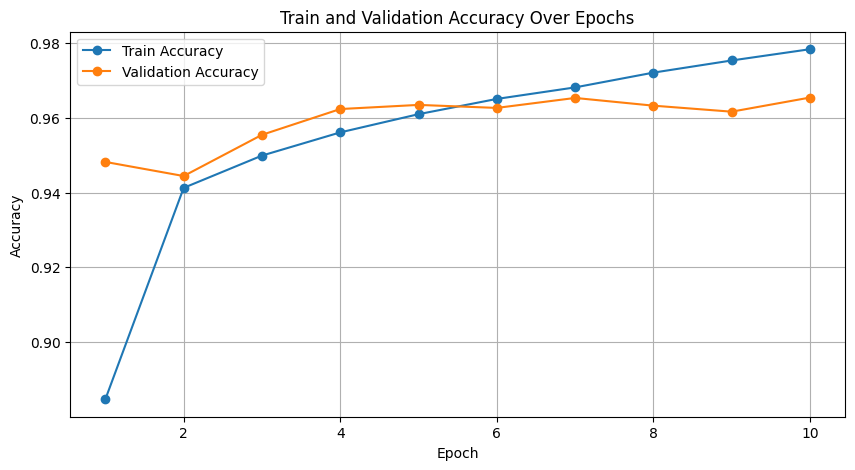

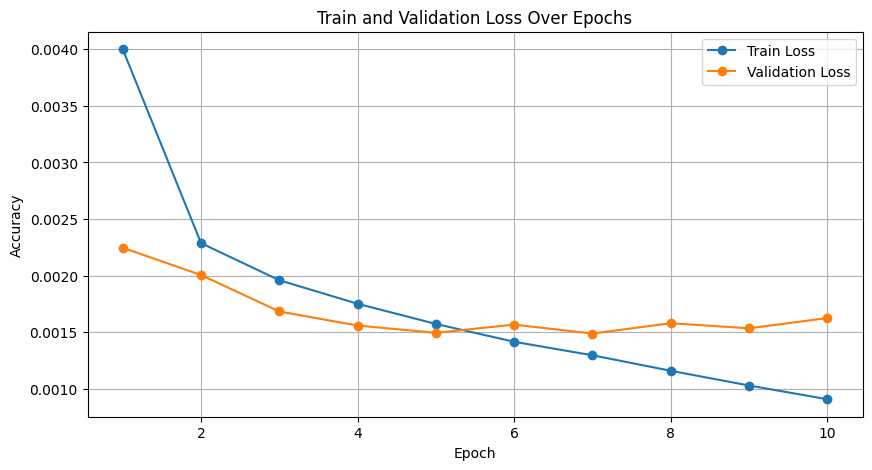

In [29]:
import matplotlib.pyplot as plt
train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, 15, 10)

In [41]:
# Specify the file path to save the model
save_path = 'model_checkpoint_celeba_5_custom_new_male.pth'

# Save the entire model (including architecture, parameters, and optimizer state)
torch.save(model, save_path)

In [28]:
model

CNN(
  (convolutional): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [27]:
loaded_model = torch.load('model_checkpoint_celeba_5_custom_new_male.pth')

In [28]:
loaded_model

CNN(
  (convolutional): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [26]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, data_loader, print_confusion_matrix=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.4f}')

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    print(f'Weighted Precision: {precision:.4f}')
    print(f'Weighted Recall: {recall:.4f}')
    print(f'Weighted F1 Score: {f1:.4f}')

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    print(f'Macro Precision: {precision_macro:.4f}')
    print(f'Macro Recall: {recall_macro:.4f}')
    print(f'Macro F1 Score: {f1_macro:.4f}')

    
    if print_confusion_matrix:
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Male", "Male"], yticklabels=["Not Male", "Male"])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

Accuracy: 0.9544
Weighted Precision: 0.9553
Weighted Recall: 0.9544
Weighted F1 Score: 0.9546
Macro Precision: 0.9493
Macro Recall: 0.9560
Macro F1 Score: 0.9523


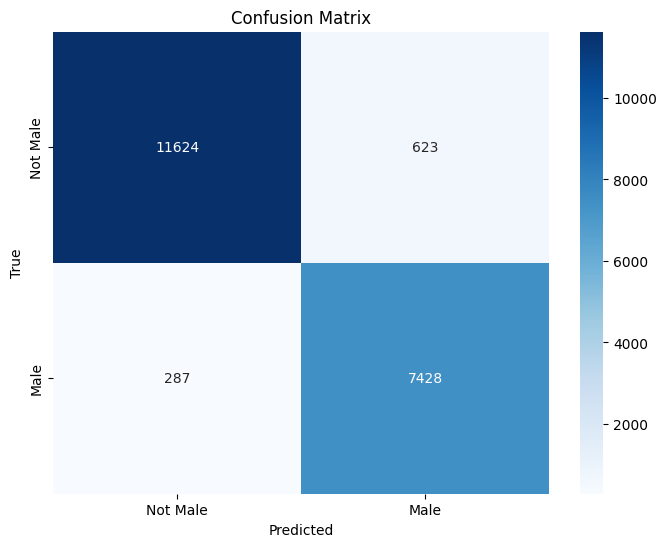

In [27]:
evaluate_model(model, test_loader)

In [67]:
iter

312

In [ ]:
correct_pred.item()

In [58]:
dataset_size

19962

In [59]:
correct_pred.item() / dataset_size

0.6112613966536419